In [44]:
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
pwd

'/home/ihor/anaconda_src/ks-challenge'

In [46]:
cd '/home/ihor/anaconda_src/ks-challenge'

/home/ihor/anaconda_src/ks-challenge


In [47]:
# Loading the Pre-trained model using Pickle
with open('./lib/models/LogisticRegression_simple_6_46.pkl', 'rb') as file:
    simple_model = pickle.load(file)

with open('./lib/models/Scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)
with open('./lib/models/LogisticRegression_scaled_full.pkl', 'rb') as file:
    full_model = pickle.load(file)
    
model = full_model

scaler_features = ['feature_46', 'feature_35',
       'feature_6', 'feature_40', 'feature_47',
       'feature_12', 'feature_4', 'feature_31',
       'feature_18', 'feature_32', 'feature_3'] 

logit_features = ['feature_46', 'feature_35',
       'feature_6', 'feature_40', 'feature_47',
       'feature_12', 'feature_4', 'feature_31',
       'feature_18', 'feature_32', 'feature_3']
# logit_features = ['feature_46', 'feature_6']

/home/ihor/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/ihor/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [48]:
def print_prediction_report(xy):
    from sklearn.metrics import confusion_matrix
    # confusion_matrix = confusion_matrix(y_test, y_pred)
    # [[t0, f1] 
    #  [f0, t1]]
    confusion_matrix = confusion_matrix(xy.target, xy.y_pred)
    target_value_counts = xy.target.value_counts()
    print(target_value_counts)
    print(confusion_matrix)
    # xy_predicted_data.shape
    print('Overall data to predicted class 1 ratio (selectivity): {:.2f}'. \
          format(xy.shape[0] / (confusion_matrix[1,1] + confusion_matrix[0,1])))
    print('Precision of class 1 prediction (precision): {:.2f}'.format(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[0,1])))
    print('(initial class 1 probability is {:.2f})'.format(target_value_counts[target_value_counts.index == 1].sum() / target_value_counts.sum()))
    print('Completeness of class 1 prediction (recall): {:.2f}'.format(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,0])))

    print('mean(target) = {:.3f}'.format(xy.target.mean()))
    print('mean(y_pred) = {:.3f}'.format(xy.y_pred.mean()))
    print('mean(y_pred_proba) = {:.3f}'.format(xy.y_pred_proba.mean()))
    
    from sklearn.metrics import classification_report
    print(classification_report(xy.target, xy.y_pred))
    #показники якості бінарної кваліфікації:
    #recall - повнота (яка частина певного класу виявлена)
    #precision - точність (яка частина припущень щодо належності до класу є вірною)

    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve
    logit_roc_auc = roc_auc_score(xy.target, xy.y_pred)
    fpr, tpr, thresholds = roc_curve(xy.target, xy.y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    # plt.savefig('Log_ROC')
    plt.show()

(8394, 53)
Scaling...
Scaling completed
Prediction...
Prediction completed
y_pred_agg      0.342929
target          0.260325
y_pred_proba    0.415392
dtype: float64
0    591
1    208
Name: target, dtype: int64
[[440 151]
 [ 85 123]]
Overall data to predicted class 1 ratio (selectivity): 2.92
Precision of class 1 prediction (precision): 0.45
(initial class 1 probability is 0.26)
Completeness of class 1 prediction (recall): 0.59
mean(target) = 0.260
mean(y_pred) = 0.343
mean(y_pred_proba) = 0.415
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       591
           1       0.45      0.59      0.51       208

    accuracy                           0.70       799
   macro avg       0.64      0.67      0.65       799
weighted avg       0.74      0.70      0.72       799



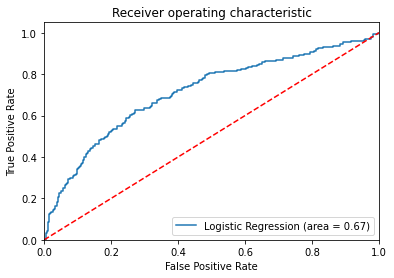

In [49]:
# fullfilename = '/tmp/flask/test_data_1000.json'
fullfilename = '/home/ihor/anaconda_src/ks-challenge/src/main/resources/data/api_test_data_full.json'

test_data = pd.read_json(fullfilename)
print(test_data.shape)
print('Scaling...')
X_scaled = pd.DataFrame(scaler.transform(test_data[scaler_features]), 
                        columns=scaler_features, index=test_data.index)[logit_features]
print('Scaling completed')

print('Prediction...')
y_pred = model.predict(X_scaled)
print('Prediction completed')
y_pred_proba = model.predict_proba(X_scaled)[:,1]
# y_pred_proba
predicted_test_data = test_data.join(pd.DataFrame({'y_pred':y_pred, 'y_pred_proba':y_pred_proba}, index=test_data.index))
predicted_test_data_agg = predicted_test_data[{'id', 'target', 'y_pred_proba'}].groupby('id').mean()
predicted_test_data_agg['y_pred_agg'] = (predicted_test_data_agg.y_pred_proba >= 0.5).mul(1)
predicted_test_data_agg[{'target', 'y_pred_proba', 'y_pred_agg'}]
print(predicted_test_data_agg[{'target', 'y_pred_proba', 'y_pred_agg'}].mean())
print_prediction_report(pd.DataFrame({
    'target':predicted_test_data_agg.target, 
    'y_pred':predicted_test_data_agg.y_pred_agg, 
    'y_pred_proba':predicted_test_data_agg.y_pred_proba}))